In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import gym_combrf

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
import os

import torch
import torch.optim as optim
import torch.nn.functional as F




In [3]:
#initialize gym environment
env = gym.make('combrf-v0')

In [4]:
#hyper-parameters
UPDATE_EVERY = 50 #how often to update the network
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983
EPS_STEP_LIMIT = 50

TRAIN_EPISODES = 20
TEST_EPISODES = 1
seed = 0

#initialize GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Examine state and action spaces

In [5]:
#reset the environment
obs = env.reset()

#size of each action
action_size = env.action_space.shape
print("Size of each action: ", action_size)

#size of observation
print("Size of each observation: ", obs.shape)
print("Observation looks like:")
print(obs)

Size of each action:  (1,)
Size of each observation:  (1, 130)
Observation looks like:
[[ 2.01393874e-09  2.08800292e-07  2.69474045e-07  1.41577402e-07
  -8.53911447e-08 -2.52605358e-07 -2.43053411e-07 -6.34194888e-08
   2.08800292e-07  2.69474045e-07  1.41577402e-07 -8.53911447e-08
  -2.52605358e-07 -2.43053411e-07 -6.34194888e-08  1.60593617e-07
   2.69474045e-07  1.41577402e-07 -8.53911447e-08 -2.52605358e-07
  -2.43053411e-07 -6.34194888e-08  1.60593617e-07  2.72227804e-07
   1.41577402e-07 -8.53911447e-08 -2.52605358e-07 -2.43053411e-07
  -6.34194888e-08  1.60593617e-07  2.72227804e-07  1.93364592e-07
  -8.53911447e-08 -2.52605358e-07 -2.43053411e-07 -6.34194888e-08
   1.60593617e-07  2.72227804e-07  1.93364592e-07 -2.08097500e-08
  -2.52605358e-07 -2.43053411e-07 -6.34194888e-08  1.60593617e-07
   2.72227804e-07  1.93364592e-07 -2.08097500e-08 -2.20422011e-07
  -2.43053411e-07 -6.34194888e-08  1.60593617e-07  2.72227804e-07
   1.93364592e-07 -2.08097500e-08 -2.20422011e-07 -2.65

## Perform random actions in the environment

In [6]:
obs = env.reset()
count = 0
ep_rwd=0
rewards =[]
actions =[]
while True:
    action = np.array([[np.random.uniform(0,1)]])
    obs, rwd, done, _ = env.step(action)
    ep_rwd += rwd
    rewards.append(rwd)
    actions.append(action)
    count +=1
    if done:
        break
print("Random TX location: {0}".format(env.tx_loc))
print("Capacity: {0}".format(env.cap))
print("Episodic score: {0} with episode length: {1} ".format(ep_rwd, count))
print(rewards)
print(actions)

Random TX location: [[500 250   0]]
Capacity: 4.4886913721313074e-08
Episodic score: 1.5 with episode length: 8 
[0.3, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3]
[array([[0.73613826]]), array([[0.92298923]]), array([[0.80657843]]), array([[0.11499593]]), array([[0.57464084]]), array([[0.53258053]]), array([[0.84008955]]), array([[0.45946958]])]


## Instantiate DDPG agent

In [7]:
#import custom classes
from Source.ddpg_rcv_agent import Agent
from Source.nn_model_2 import Actor, Critic
from Source.ddpg_rcv_agent import Agent, ReplayBuffer, OUNoise
from collections import deque

#reset the environment
obs = env.reset()

state_size = obs.shape[1]
action_size = env.action_space.shape[0]
print(action_size)
print(state_size)
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

print(type(obs))
obs_tensor = torch.from_numpy(obs).float().to(device)
print(obs_tensor)

1
130
<class 'numpy.ndarray'>
tensor([[ 1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06,
         -1.9416e-06,  1.9416e-06, -1.9416e-06, -1.9416e-06,  1.9416e-06,
         -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,
          1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,
          1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06, -1.9416e-06,
          1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06,
         -1.9416e-06,  1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06,
         -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,
         -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,
          1.9416e-06, -1.9416e-06,  1.9416e-06,  1.9416e-06, -1.9416e-06,
          1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06,
         -1.9416e-06, -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06,
         -1.9416e-06,  1.9416e-06, -1.9416e-06,  1.9416e-06,  4.2718e-07,
        

In [8]:
agent.reset()

In [9]:
obs = env.reset()

print(env.action_space.sample())
action = agent.act(obs)
print(action)

[2.8318057]
[[0.44657907]]


## DDPG Training

Episode 100	Average Score: 0.58
Episode old_actions: [array([[0.9236951]], dtype=float32), array([[0.9691873]], dtype=float32), array([[1.0316219]], dtype=float32), array([[1.0141673]], dtype=float32), array([[1.0248249]], dtype=float32), array([[1.0976518]], dtype=float32), array([[1.0723082]], dtype=float32), array([[1.1298378]], dtype=float32)]
Episode actions: [array([[0.96184754]], dtype=float32), array([[0.98459363]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32)]
Episode 200	Average Score: 1.22
Episode old_actions: [array([[-0.9185127]], dtype=float32), array([[-0.8569916]], dtype=float32), array([[-0.80104464]], dtype=float32), array([[-0.7556934]], dtype=float32), array([[-0.69227386]], dtype=float32), array([[-0.68682057]], dtype=float32), array([[-0.71471465]], dtype=float32), array([[-0.6554318]], dtype=float32)]
Episode action

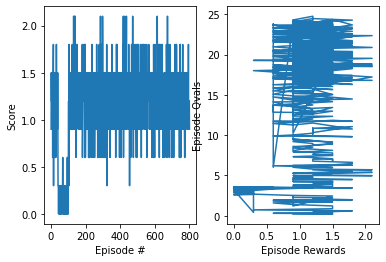

In [10]:
train_episodes = 800
print_every= 100

scores_deque = deque(maxlen=print_every)
scores = []
ep_qvals =[]
timestep = 0
for i_episode in range(1,train_episodes+1):
    
    # reset the environment
    obs = env.reset()
    agent.reset()
    ep_rwds = []
    ep_actions =[]
    ep_old_actions =[]
    score = 0
    ep_qval = 0
    while True:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.step(obs, action, reward, next_obs, done)
        obs = next_obs
        score+= reward
        timestep+=1
        
        agent.critic_local.eval()
        obs_tensor = torch.from_numpy(obs).float().to(device)
        action_tensor = torch.from_numpy(action).float().to(device)
        #print(agent.critic_local(obs_tensor, action_tensor).cpu().data.item())
        ep_qval += agent.critic_local(obs_tensor, action_tensor).cpu().data.item()
        agent.critic_local.train()
        
        ep_rwds.append(reward)
        ep_actions.append(action)
        ep_old_actions.append(agent.old_action)
        if done:
            break
            
    scores_deque.append(score)
    scores.append(score)
    ep_qvals.append(ep_qval)
    #print('\rEpisode {}\t, TX loc: {}\t, Score: {:.2f}\n'.format(i_episode, env.tx_loc, score), end="")
    
    #print(ep_rwds)
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        print("Episode old_actions: {}".format(ep_old_actions))
        print("Episode actions: {}".format(ep_actions))
        
#torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')    
agent.save_checkpoint(timestep)

fig = plt.figure()
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

ax2 = fig.add_subplot(122)
plt.plot(scores, ep_qvals)
plt.ylabel('Episode Qvals')
plt.xlabel('Episode Rewards')
plt.show() 

In [11]:
print(ep_qvals[0])
print(ep_qval)

0.21753141097724438
24.30461835861206


## Testing the DDPG agent

env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
env rssi value:(-5.408187270380822e-07-1.4450223372694968e-06j)
TX loc: [[350 400   0]], episode score: 0.3

TX_beam dir: [ 0.35355339+0.j         -0.16886826-0.31061795j -0.19223977+0.29672187j
  0.35250782+0.02717049j -0.14449795-0.32267684j -0.21447426+0.2810708j
  0.3493773 +0.05418027j -0.11927299-0.33282721j]
eps rwds: [0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Episode old actions: [array([[-0.99999994]], dtype=float32), array([[-0.99999994]], dtype=float32), array([[-0.99999994]], dtype=float32), array([[-0.99999994]], dtype=float32), array

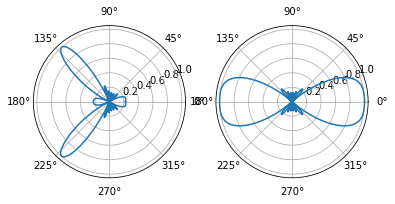

In [22]:
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

agent.load_checkpoint(timestep)

score = 0.0
eps_rwd =[]
obs = env.reset()
#agent.reset()
agent.actor_local.eval()
agent.critic_local.eval()
agent.actor_target.eval()
agent.critic_target.eval()
ep_actions =[]
ep_old_actions =[]
while True:
    #obs_tensor = torch.from_numpy(obs).float().to(device)
    
    #with torch.no_grad():
    #    action =agent.actor_local(obs_tensor).cpu().data.numpy()
        #print("old_action: {}", action)
    #    best_action = agent.critic_local(obs_tensor)

    action =  agent.act(obs,add_noise=False)#.cpu().data.numpy()
    #action == np.clip(action, 0, 2*np.pi)
    
    #action_tensor = agent.actor_local(obs_tensor).to(device)
    #print(obs, action)
    #q_val = agent.critic_local(obs_tensor, action_tensor).cpu().data.numpy()
    obs, rwd, done, _ = env.step(action)
    print("env rssi value:{}".format(env.rssi_val))
    ep_actions.append(env.action)
    ep_old_actions.append(agent.old_action)
    score +=rwd
    eps_rwd.append(rwd)
    if done:
        break
print("TX loc: {0}, episode score: {1}\n".format(env.tx_loc, score))
print("TX_beam dir: {}".format(env.tx_beam))
print("eps rwds: {}\n".format(eps_rwd))
print("Episode old actions: {}".format(ep_old_actions))
print("Applied RX directions: {}".format(ep_actions))

from Source.misc_fun.utils import plotbeam
print(env.channel.az_aod[0])
print(ep_actions[-1][0])
tx_theta, tx_gr = plotbeam(env.channel.az_aod[0], env.N_tx)
rx_theta, rx_gr = plotbeam(ep_actions[-1][0], env.N_rx)
ax1 = plt.subplot(121, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(122, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()
